# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [1]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/elastic/ember.git

In [3]:
import Ember_Wrapper

## Requirements

The requirements file is this output copy pasted into a txt file.

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
hyperopt==0.2.5
shap==0.40.0


## Load Data

In [5]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to read in the Excel file every time to resume progress.

In [6]:
# pd.to_pickle(df1, "./data.pkl")

In [7]:
df1 = pd.read_pickle("./data.pkl")

In [8]:
df2 = pd.read_excel("./Data/raw_train.xlsx")

Checking number of malware entries.

In [9]:
sum(df1['category'])

900

In [10]:
df1.shape

(18000, 714)

In [11]:
900/18000

0.05

5%, super imbalanced.

## EDA

### Visualizations Team here:
### try plotting distributions of certain features to compare them between the malware and not malware tables

In [12]:
df1.head(5)

,sha256,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,...,datadirectories_13_name,datadirectories_13_size,datadirectories_13_virtual_address,datadirectories_14_name,datadirectories_14_size,datadirectories_14_virtual_address,datadirectories_15_name,datadirectories_15_size,datadirectories_15_virtual_address,category
0,15f88c44e29e74965cbec984cd4244786eeb4ccde02328...,127242,9185,3818,3127,13300,1594,1781,1493,9938,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
1,29bb2a854de0f99bdb7120870ad42af6a3b5b5c6fc3578...,36152,2617,4120,876,1711,755,672,521,2278,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
2,5cd8667d8375bf799fe89ac9b74cf08bf69dfa18a4e551...,39986,7112,7953,6604,6542,6441,5869,6422,6224,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
3,ce63706c0adf4851a8d2eb26fa97750cfaec7345151367...,253873,32714,22629,17500,15355,6691,10881,4258,11992,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0
4,5e65dd9986fc47c5fe45208fab5e1c78730699800eaf96...,12464,1020,502,264,1918,218,262,91,846,...,DELAY_IMPORT_DESCRIPTOR,0,0,CLR_RUNTIME_HEADER,0,0,???,0,0,0


In [13]:
list(df1)

['sha256',
 'histogram_0',
 'histogram_1',
 'histogram_2',
 'histogram_3',
 'histogram_4',
 'histogram_5',
 'histogram_6',
 'histogram_7',
 'histogram_8',
 'histogram_9',
 'histogram_10',
 'histogram_11',
 'histogram_12',
 'histogram_13',
 'histogram_14',
 'histogram_15',
 'histogram_16',
 'histogram_17',
 'histogram_18',
 'histogram_19',
 'histogram_20',
 'histogram_21',
 'histogram_22',
 'histogram_23',
 'histogram_24',
 'histogram_25',
 'histogram_26',
 'histogram_27',
 'histogram_28',
 'histogram_29',
 'histogram_30',
 'histogram_31',
 'histogram_32',
 'histogram_33',
 'histogram_34',
 'histogram_35',
 'histogram_36',
 'histogram_37',
 'histogram_38',
 'histogram_39',
 'histogram_40',
 'histogram_41',
 'histogram_42',
 'histogram_43',
 'histogram_44',
 'histogram_45',
 'histogram_46',
 'histogram_47',
 'histogram_48',
 'histogram_49',
 'histogram_50',
 'histogram_51',
 'histogram_52',
 'histogram_53',
 'histogram_54',
 'histogram_55',
 'histogram_56',
 'histogram_57',
 'histogram_5

In [14]:
malware = df1[df1['category'] == 1]
not_malware = df1[df1['category'] == 0]

In [15]:
def dist_plotter(feature_name): #random function, make some more
    fig, ax = plt.subplots(2,1)
#     ax.set(ylabel='common ylabel', title=feature_name)
    sns.violinplot(malware[feature_name], inner="quartile", ax=ax[0], color='r')
    sns.violinplot(not_malware[feature_name], inner="quartile", ax=ax[1], color='r')

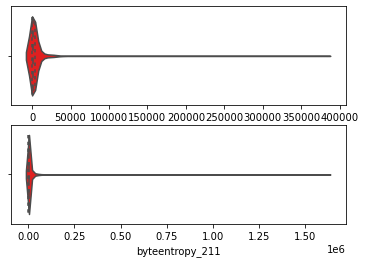

In [16]:
dist_plotter('byteentropy_211')

## Undersampling

Since only 5% of entries are malware, we want a similar 50/50 split between malware and not malware. Could also use SMOTE.

In [17]:
majority = df2[df2.category==0] # Majority class
minority = df2[df2.category==1] # Minority class

In [18]:
majority_undersampled = resample(majority, replace=False, n_samples=900) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    900
1    900
Name: category, dtype: int64

In [19]:
Ember_Wrapper.create_vectorize_features(df_undersampled)

In [20]:
X = np.load('./X_data.npy')
y = np.load('./y_data.npy')
print('X.shape', X.shape)
print('%Malware:', sum(y) / len(y))

X.shape (1800, 2381)
%Malware: 0.5


In [21]:
# df = df_undersampled #make it a new df

In [22]:
# X = df.drop('category', axis=1) #X is everything but the 'category' col

In [23]:
# y = df['category'] #y is just the target column

In [24]:
# X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [25]:
# print(X.shape, y.shape) #sanity check arrays

## Feature Selection with ANOVA

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #train test split 80/20

Ideally should select features after heatmaps/correlation plots/distributions etc but skipped for now.

This is automatic but more of a "black box".

PCA would also go here.

In [27]:
# fs = SelectKBest(score_func=f_classif, k=600) #THIS K IS HOW MANY FEATURES YOU WANT
# fs.fit(X_train, y_train)
# mask = fs.get_support()
# new_features = X_train.columns[mask]

In [28]:
# X_train_fs = X_train[new_features]
# X_test_fs = X_test[new_features]

In [29]:
X_train_fs = X_train
X_test_fs = X_test

In [30]:
# for i in range(len(fs.scores_[:10])):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
#     plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#     plt.show()

Now we can use X_train_fs and X_test_fs in place of X_train and X_test.

In [31]:
print(X_train_fs.shape, X_test_fs.shape)

(1440, 2381) (360, 2381)


In [32]:
print(y_train.shape, y_test.shape)

(1440,) (360,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well.

In [33]:
def modeler(model):
    model.fit(X_train_fs, y_train) #fit specified model
    y_pred = model.predict(X_test_fs) #predict on test set
    f1 = f1_score(y_test, y_pred) #get f1 score
    print('F1 Score:', f1)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    #this plots the ROC curve, play around iwth it
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc = auc(fpr, tpr)
    print(roc_auc_score(y_test, y_pred))
    print(precision_score(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

F1 Score: 0.6888361045130642
[[ 84  96]
 [ 35 145]]
0.6361111111111112
0.6016597510373444
0.8055555555555556


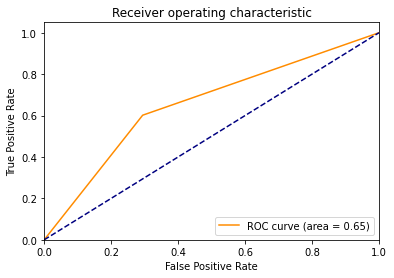

In [34]:
lr = LogisticRegression()
modeler(lr)

F1 Score: 0.9464788732394367
[[173   7]
 [ 12 168]]
0.9472222222222222
0.96
0.9333333333333333


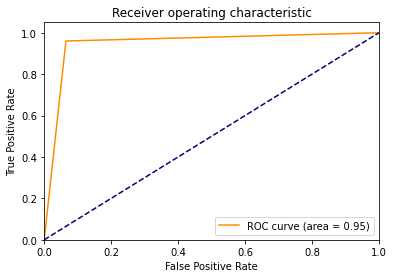

In [35]:
lgbm = lgb.LGBMClassifier()
modeler(lgbm)

F1 Score: 0.9235127478753541
[[170  10]
 [ 17 163]]
0.9249999999999999
0.9421965317919075
0.9055555555555556


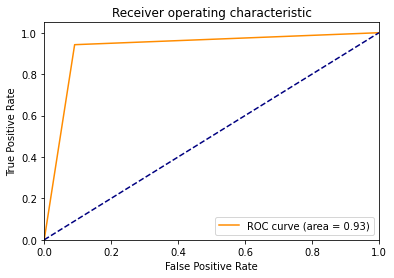

In [36]:
xgbc = xgb.XGBClassifier(eval_metric='logloss')
modeler(xgbc)

F1 Score: 0.888268156424581
[[161  19]
 [ 21 159]]
0.888888888888889
0.8932584269662921
0.8833333333333333


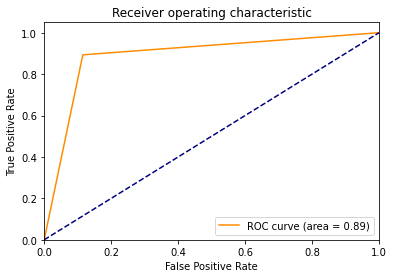

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
modeler(rf)

F1 Score: 0.5902335456475585
[[ 28 152]
 [ 41 139]]
0.4638888888888889
0.47766323024054985
0.7722222222222223


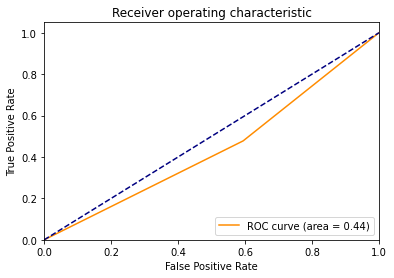

In [38]:
from sklearn.svm import SVC
svm = SVC()
modeler(svm)

F1 Score: 0.7113402061855669
[[110  70]
 [ 42 138]]
0.6888888888888889
0.6634615384615384
0.7666666666666667


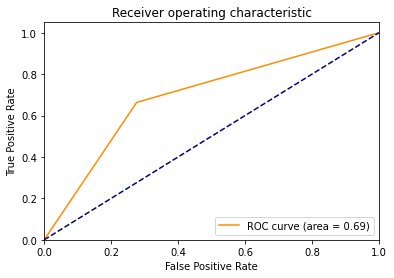

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
modeler(knn)

F1 Score: 0.8248587570621468
[[152  28]
 [ 34 146]]
0.8277777777777777
0.8390804597701149
0.8111111111111111


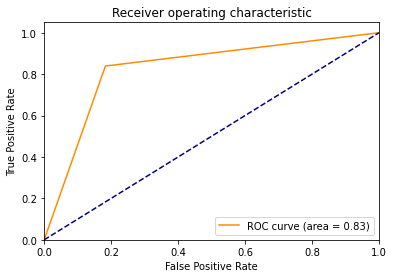

In [40]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
modeler(dt)

Best ones seem to be LGBM and XGB. Ideal ROC graph looks hugs the top left corner.

## Hyperparameter Optimization

Time to tune with Hyperopt.
(Scaling/normalizing isn't needed for gradient boosted decision trees so skip it)

# EVERYONE CAN TRY OPTIMIZING WITH DIFFERENT HYPERPARAMETERS LIKE IN THE COMMENTED OUT LINES, check the user docs for more parameters

In [41]:
# #hyperparameter domain to search over
# hyperparam_space = {
#     'num_leaves':       hp.choice('num_leaves', np.arange(30, 250, 1)),
#     'learning_rate':    hp.quniform('learning_rate', 0, 0.3, 0.01),
#     'max_depth':        hp.choice('max_depth', np.arange(2, 100, 1, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
#     'subsample':        hp.uniform('subsample', 0.5, 1),
# }

Following code takes a couple minutes to run:

In [42]:
# def score(params): #function to train and test different hyperparams
#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train_fs, y_train, early_stopping_rounds=20,
#              eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
# #     y_pred = model.predict(X_test_fs)
# #     score = mean_squared_error(y_test, y_pred)
#     score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
#     print(score)
#     return score
            
# def optimize(trials, space): #fmin is the main library function
#     best = fmin(score, space, algo=tpe.suggest, max_evals=10)
#     return best
            
# trials = Trials() #database that store completed hyperparameters and score
# best_params = optimize(trials, hyperparam_space) #calls fmin

# #finds best hyperparameters
# # space_eval(hyperparam_space, best_params)

In [43]:
# best_params

In [44]:
# lgbm_model = lgb.LGBMClassifier(**best_params)
# lgbm_model.fit(X_train_fs, y_train)
# preds = [pred[1] for pred in lgbm_model.predict_proba(X_test_fs)]
# score = roc_auc_score(y_test, preds, average='weighted')
# print('auc_roc score: ', score)

# y_pred = lgbm_model.predict(X_test_fs)
# f1 = f1_score(y_test, y_pred) #get f1 score
# print('F1 Score:', f1)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [45]:
# shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test_fs)
# shap.summary_plot(shap_values, X_test_fs)

In [46]:
# lgb.plot_importance(lgbm_model, max_num_features=20)
# plt.figure(figsize=(25, 12))
# plt.show()

In [47]:
#hyperparameter domain to search over
hyperparam_space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 10, 1, dtype=int)), #larger values = overfitting
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, 1, dtype=int)), #larger values = overfitting
    'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01), #aka eta = step size shrinkage to prevent overfitting
#     'gamma': hp.quniform('gamma', 0, 1, 0.05), #gamma: min loss reduction to partition leaf nodes (for overfitting)
#     'min_child_weight': hp.quniform('min_child_weight', 1, 8, 0.5),
#     'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
}

In [48]:
def xgb_score(params): #function to train and test different hyperparams
    model = xgb.XGBClassifier(**params, eval_metric='logloss')
    model.fit(X_train_fs, y_train, early_stopping_rounds=20,
             eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
    score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
    print(score)
    return {'loss': score, 'status': STATUS_OK}
            
def xgb_optimize(trials, space): #fmin is the main library function
    best = fmin(xgb_score, space, algo=tpe.suggest, max_evals=5)
    return best
            
trials = Trials() #database that store completed hyperparameters and score
best_xgb_params = xgb_optimize(trials, hyperparam_space) #calls fmin

[0]	validation_0-logloss:0.45701	validation_1-logloss:0.48301                                                      
[1]	validation_0-logloss:0.35103	validation_1-logloss:0.40346                                                      
[2]	validation_0-logloss:0.27094	validation_1-logloss:0.33702                                                      
[3]	validation_0-logloss:0.22714	validation_1-logloss:0.30496                                                      
[4]	validation_0-logloss:0.18775	validation_1-logloss:0.27763                                                      
[5]	validation_0-logloss:0.16098	validation_1-logloss:0.24772                                                      
[6]	validation_0-logloss:0.14136	validation_1-logloss:0.23522                                                      
[7]	validation_0-logloss:0.12429	validation_1-logloss:0.23272                                                      
[8]	validation_0-logloss:0.11423	validation_1-logloss:0.22606           

[27]	validation_0-logloss:0.00666	validation_1-logloss:0.21491                                                     
[28]	validation_0-logloss:0.00641	validation_1-logloss:0.21393                                                     
[29]	validation_0-logloss:0.00621	validation_1-logloss:0.21583                                                     
[30]	validation_0-logloss:0.00599	validation_1-logloss:0.21549                                                     
[31]	validation_0-logloss:0.00580	validation_1-logloss:0.21509                                                     
[32]	validation_0-logloss:0.00563	validation_1-logloss:0.21531                                                     
[33]	validation_0-logloss:0.00547	validation_1-logloss:0.21669                                                     
[34]	validation_0-logloss:0.00532	validation_1-logloss:0.21877                                                     
[35]	validation_0-logloss:0.00522	validation_1-logloss:0.21940          

[54]	validation_0-logloss:0.00415	validation_1-logloss:0.20007                                                     
[55]	validation_0-logloss:0.00409	validation_1-logloss:0.19988                                                     
[56]	validation_0-logloss:0.00403	validation_1-logloss:0.20145                                                     
[57]	validation_0-logloss:0.00398	validation_1-logloss:0.20036                                                     
[58]	validation_0-logloss:0.00393	validation_1-logloss:0.20127                                                     
[59]	validation_0-logloss:0.00389	validation_1-logloss:0.20171                                                     
[60]	validation_0-logloss:0.00384	validation_1-logloss:0.20314                                                     
[61]	validation_0-logloss:0.00379	validation_1-logloss:0.20344                                                     
[62]	validation_0-logloss:0.00375	validation_1-logloss:0.20331          

[60]	validation_0-logloss:0.05113	validation_1-logloss:0.18632                                                     
[61]	validation_0-logloss:0.05007	validation_1-logloss:0.18553                                                     
[62]	validation_0-logloss:0.04934	validation_1-logloss:0.18526                                                     
[63]	validation_0-logloss:0.04789	validation_1-logloss:0.18352                                                     
[64]	validation_0-logloss:0.04661	validation_1-logloss:0.18350                                                     
[65]	validation_0-logloss:0.04516	validation_1-logloss:0.18349                                                     
[66]	validation_0-logloss:0.04377	validation_1-logloss:0.18184                                                     
[67]	validation_0-logloss:0.04272	validation_1-logloss:0.18156                                                     
[68]	validation_0-logloss:0.04140	validation_1-logloss:0.18024          

[29]	validation_0-logloss:0.01026	validation_1-logloss:0.19344                                                     
[30]	validation_0-logloss:0.00977	validation_1-logloss:0.19199                                                     
[31]	validation_0-logloss:0.00932	validation_1-logloss:0.19179                                                     
[32]	validation_0-logloss:0.00895	validation_1-logloss:0.19079                                                     
[33]	validation_0-logloss:0.00861	validation_1-logloss:0.18825                                                     
[34]	validation_0-logloss:0.00826	validation_1-logloss:0.18927                                                     
[35]	validation_0-logloss:0.00797	validation_1-logloss:0.18835                                                     
[36]	validation_0-logloss:0.00769	validation_1-logloss:0.19028                                                     
[37]	validation_0-logloss:0.00748	validation_1-logloss:0.19001          

In [54]:
# best_xgb_params = {'learning_rate': 0.21, 'max_depth': 1, 'n_estimators': 392}
best_xgb_params

{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 0}

In [55]:
xgb_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='logloss')
eval_set = [(X_train_fs, y_train), (X_test_fs, y_test)]

xgb_model.fit(X_train_fs, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)


results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
    
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
# xgb_model.save_model("xgb_model.txt")

## Testing on Output 

In [ ]:
# saved_model = xgb.Booster()
saved_model=xgb_model()
# saved_model.load_model("xgb_model.txt")

In [ ]:
X_test_D = xgb.DMatrix(X_test_fs)

In [ ]:
y_pred = saved_model.predict(X_test_D)
f1=f1_score(y_test, (y_pred > 0.6622))
print('F1 Score:', f1)
print(confusion_matrix(y_test, (y_pred > 0.6622)))
print(classification_report(y_test, (y_pred > 0.6622)))

In [ ]:
cf_matrix = confusion_matrix(y_test, (y_pred > 0.6622))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix XGB\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

# testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print()

threshold, fpr = find_threshold(y_test, y_pred, 0.01)
fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
print("XGB Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(y_test, y_pred, 0.001)
fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
print("XGB Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

## try setting 0.01 to 0.1

In [ ]:
shap_values = shap.TreeExplainer(saved_model).shap_values(X_test_fs)
shap.summary_plot(shap_values, X_test_fs)

In [ ]:
xgb.plot_importance(saved_model, importance_type='cover', max_num_features=20)
plt.figure(figsize=(25, 12))
plt.show()

## Conclusions

## Visualizations should include the above ROC plots, SHAP plots, as well as the built in feature importance plots.